In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f4f41780da0>


In [2]:
base_input = '../../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['A']
['B']
['C']
-----
{'A'}
{'A'}
set()
-----
{'A'}
{'B'}
{'A'}
False
Allowed edges: 
('A', 'B')
Connected Nodes:  ['A', 'B']
Connected Edges:  [('A', 'B')]
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', 'C')
New node added--1
['A', 'B']
{('A', 'B'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3]
-----
{'A'}
{'C'}
{'A'}
False
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Connected Nodes:  ['A', 'C']
Connected Edges:  [('A', 'C')]
Allowed edges: 
('B', 'C')
New node added--1
['A', 'C']
{('A', 'B'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3, 4]
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', '

In [3]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [1.0, 1.0, 1.0, 1.5923, 1.5923, 1.5923] #Max yield Simruntime = 10sec
new_kon =[1.0, 1.0, 1.0, 1.0, 1.0, 1.0] * np.array([1e6])#Poor yield Simruntime = 1sec

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=to

In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)
runtime = 50
sim = VecSim(vec_rn, runtime, device='cpu')
y = sim.simulate()

Using CPU
Current time:  tensor(49.9948, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time:  tensor(50.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.


In [6]:
print("Done")

Done


<IPython.core.display.Javascript object>


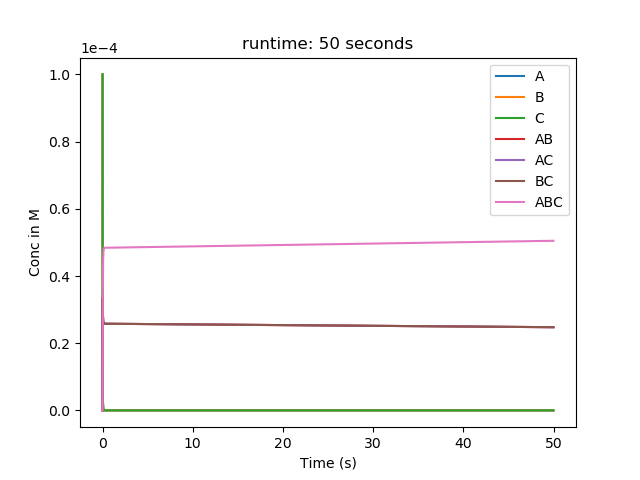

Text(0.5, 1.0, 'runtime: 50 seconds')

In [7]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots()
nodes_list = ['A','B','C','AB','BC','AC','ABC']
sim.plot_observable(nodes_list, ax=ax)
ax.set_title("runtime: " + str(runtime) + " seconds")

In [8]:
print(vec_rn.copies_vec)
print(vec_rn.kon)
print(sim.steps)

tensor([5.4845e-10, 5.4845e-10, 5.4845e-10, 2.4760e-05, 2.4760e-05, 2.4760e-05,
        5.0480e-05], dtype=torch.float64, grad_fn=<MaxBackward2>)
Parameter containing:
tensor([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.],
       dtype=torch.float64, requires_grad=True)
[0.003333333333333331, 0.0083333127657225, 0.014999799659996788, 0.023181364655122175, 0.032631951973318384, 0.043078874048482985, 0.054270684162726866, 0.06599974573831278, 0.07810629236158306, 0.09047286941633702, 0.1030155100990472, 0.11567498920717686, 0.12840944306379287, 0.1411885638518438, 0.15398912221883523, 0.16679144021365944, 0.1795764503508017, 0.19232306037874608, 0.20500568888276702, 0.21759207551752455, 0.2300418324375753, 0.24230663346097792, 0.25433315396550016, 0.26606934932155907, 0.27747305941931416, 0.2885199847793337, 0.2992076126106067, 0.3095536394027551, 0.31959030898857693, 0.3293575003778524, 0.33889683627043066, 0.3482477342428729, 0.3574453039506306, 0.3665195800138889, 0.3754

In [9]:
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

{'A': 0, 'B': 1, 'C': 2, 'AB': 3, 'AC': 4, 'BC': 5, 'ABC': 6}
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + B  ->  AB
Net flux:  tensor([6.7897e-09], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(1000000., dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.0003], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1000000.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 0}
Reaction:  A + C  ->  AC
Net flux:  tensor([6.7897e-09], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(1000000., dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.0003], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1000000.0, 'k_off': None, 'lcf': 1, 'rxn_score': te

In [10]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

BC  :  tensor([-2.0369e-08], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([-2.0369e-08], dtype=torch.float64, grad_fn=<AddBackward0>)
AC  :  tensor([-2.0369e-08], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([-1.9985e-17], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([-1.9985e-17], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([-1.9985e-17], dtype=torch.float64, grad_fn=<AddBackward0>)
ABC  :  tensor([4.0738e-08], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([5.4845e-10, 5.4845e-10, 5.4845e-10, 2.4760e-05, 2.4760e-05, 2.4760e-05,
        5.0480e-05], dtype=torch.float64, grad_fn=<MaxBackward2>)
Parameter containing:
tensor([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.],
       dtype=torch.float64, requires_grad=True)
